#### Code for Validation Figure


### - This is a code to create a validation Figure for the Methods Section
####        - create S & T comparison for validation. It uses some code from Fig 2, but for different depths and also for salinity.


In [1]:
pwd

'/home/581/ns3783/Scripts/Figures'

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cftime
from glob import glob
import dask
import os
import datetime
import matplotlib.colors as col
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as col
from scipy import interpolate


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
# from cosima_cookbook import distributed as ccd

In [2]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34689/status,
Dashboard: /proxy/34689/status,Workers: 7
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40379,Workers: 7
Dashboard: /proxy/34689/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:43091,Total threads: 4
Dashboard: /proxy/41065/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:36515,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

##initially I calculated the model just for 2012, but after having a look on what sort of data the seals had, I decided to do all months from 2004-2018,
## so we would be covering the same period on both
first_year = '2004'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

### Load temperature data at determined depth

In [4]:
# load temperature data at 100m:

# cut data for the extended area (Shack + Vincennes)
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -230)

temp = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_150m = temp.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=150,method='nearest')
temp_550m = temp.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=550,method='nearest')

# load data
temp_150m = temp_150m.load()
temp_550m = temp_550m.load()

In [5]:
#average for temperature 
temp_150m_avg = temp_150m.mean('time')
temp_550m_avg = temp_550m.mean('time')

### Load salinity data at determined depth

In [6]:
# load temperature data at 100m:

# cut data for the extended area (Shack + Vincennes)
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -230)

sal = cc.querying.getvar(iaf_cycle3,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
sal_150m = sal.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=150,method='nearest')
sal_550m = sal.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=550,method='nearest')

# load data
sal_150m = sal_150m.load()
sal_550m = sal_550m.load()

In [7]:
#average for temperature 
sal_150m_avg = sal_150m.mean('time')
sal_550m_avg = sal_550m.mean('time')

### Bathymetry

In [8]:
# import bathymetry and the land/ocean mask to add to plot:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# create land mask from the bathymetry:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

### SKIP TO "OPEN SAVED SEAL DATA" IF YOU'VE DONE THIS PART ALREADY

#### LOAD SEALS 

## Get model grid data and temperature climatology:

## Select out profiles in correct region:

#### Improvements on this figure: take out winter profiles, sort profiles 
#### Fix it in a way they don't go much shallower than 400m. 

## Interpolate MEOP profiles onto model depth grid and convert to conservative temp:


### Interpolating the seal data to the model grid. >> this is working know, but I am not sure what exactly I have done that got it right. 

### check how those profles are looking

### saving data

## Open saved seal data:

In [9]:
outpath = '/g/data/v45/ns3783/VB_MEOP_profiles_interpolated_sal&T.nc'
profile_data = xr.open_dataset(outpath)
lat_obs = profile_data.lat_obs
lon_obs = profile_data.lon_obs
month_obs = profile_data.month_obs
year_obs = profile_data.year_obs
temp_interp = profile_data.temp_interp
sal_interp = profile_data.sal_interp
date = profile_data.date

# need to assign lat/lon coords for binning:
temp_interp = temp_interp.assign_coords({'lon':lon_obs,'lat':lat_obs})
sal_interp = sal_interp.assign_coords({'lon':lon_obs,'lat':lat_obs})

In [10]:
np.unique(year_obs)

array([2004., 2005., 2007., 2008., 2009., 2010., 2011., 2012., 2013.,
       2014., 2015., 2016., 2017., 2018., 2019.])

## PLOT T & SALT to see if all is good

#### Here I played around a little to decide which slices to choose. Whatever you decide here, you have to go and change the slices you load from the model at the beginning

Text(0.5, 0, 'Longitude')

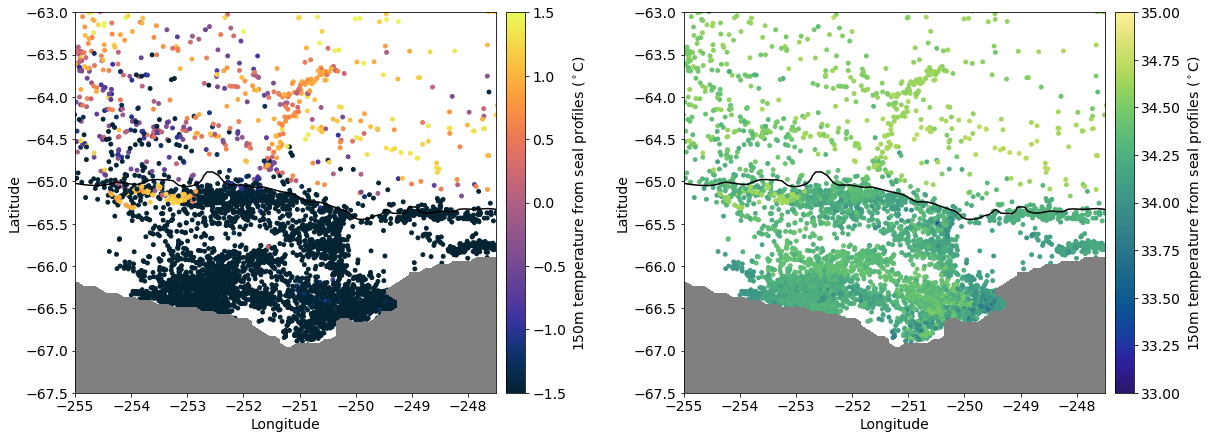

In [11]:
# plot 200m slice:
fontsize = 14
depth_slice = 150

plt.figure(figsize=(20,7))
plt.subplot(1, 2, 1)
sc = plt.scatter(lon_obs-360,lat_obs,c=temp_interp.sel(st_ocean=depth_slice,method='nearest'),s=15,cmap=cmocean.thermal,vmin=-1.5,vmax=1.5)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temperature from seal profiles ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67.5, -63))
plt.xlim((-255, -247.5))
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)

plt.subplot(1, 2, 2)
sc = plt.scatter(lon_obs-360,lat_obs,c=sal_interp.sel(st_ocean=depth_slice,method='nearest'),s=15,cmap=cmocean.haline,vmin=33,vmax=35)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temperature from seal profiles ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67.5, -63))
plt.xlim((-255, -247.5))
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)
#figure_path = figdir+'/seal_temp_map_'+str(depth_slice)+'m.png'
#plt.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1,facecolor='white')

## Bin seal data into lat/lon bins:
### that is because they are a bit on top of one another and my attempt at sortng failed.

In [12]:
# set up new bins:
lon_bins = np.arange(104, 114, .1)
lat_bins = np.arange(-76, -60, .1) 

lon_mid = (lon_bins[1:] + lon_bins[:-1])/2
lat_mid = (lat_bins[1:] + lat_bins[:-1])/2

### depth = 150* we can define these depths at the top, by checking the data before bining on the plot above. I have previously chosen 4 depths (see validation_figure.ipynd) and have then reduced to this 

In [13]:
## just do for a single depth slice:
depth = 150
temp_slice = temp_interp.sel(st_ocean=depth,method='nearest')
sal_slice = sal_interp.sel(st_ocean=depth,method='nearest')
# single slice:
binned_meop_temp150 = xr.DataArray(np.zeros((len(lat_bins)-1, len(lon_bins)-1)), coords = [lat_mid, lon_mid], 
                                dims = ['lat_bin', 'lon_bin'], name = 'binned meop temperature data')
binned_meop_sal150 = xr.DataArray(np.zeros((len(lat_bins)-1, len(lon_bins)-1)), coords = [lat_mid, lon_mid], 
                                dims = ['lat_bin', 'lon_bin'], name = 'binned meop salinity data')
# full depth:
#binned_meop_temp = xr.DataArray(np.zeros((len(st_ocean),len(lat_bins)-1, len(lon_bins)-1)), coords = [st_ocean,lat_mid, lon_mid], 
#                                dims = ['st_ocean','lat_bin', 'lon_bin'], name = 'binned meop temperature data')
                                                      
for i in range(len(lon_bins)-1):
    #if i%50 == 0:
    print('lon bin '+str(i)+'/'+str(len(lon_bins)-1))
    for j in range(len(lat_bins)-1):
        bin_mask = temp_slice.where(temp_slice.lon <= lon_bins[i+1]).where(temp_slice.lon > lon_bins[i])\
            .where(temp_slice.lat <= lat_bins[j+1]).where(temp_slice.lat > lat_bins[j]) * 0 + 1
        binned_meop_temp150[j,i] = (temp_slice * bin_mask).mean(dim = 'profile_number')
        binned_meop_sal150[j,i] = (sal_slice * bin_mask).mean(dim = 'profile_number')
        #binned_meop_temp[:,j,i] = (temp_interp * bin_mask).mean(dim = 'profile_number')

lon bin 0/99
lon bin 1/99
lon bin 2/99
lon bin 3/99
lon bin 4/99
lon bin 5/99
lon bin 6/99
lon bin 7/99
lon bin 8/99
lon bin 9/99
lon bin 10/99
lon bin 11/99
lon bin 12/99
lon bin 13/99
lon bin 14/99
lon bin 15/99
lon bin 16/99
lon bin 17/99
lon bin 18/99
lon bin 19/99
lon bin 20/99
lon bin 21/99
lon bin 22/99
lon bin 23/99
lon bin 24/99
lon bin 25/99
lon bin 26/99
lon bin 27/99
lon bin 28/99
lon bin 29/99
lon bin 30/99
lon bin 31/99
lon bin 32/99
lon bin 33/99
lon bin 34/99
lon bin 35/99
lon bin 36/99
lon bin 37/99
lon bin 38/99
lon bin 39/99
lon bin 40/99
lon bin 41/99
lon bin 42/99
lon bin 43/99
lon bin 44/99
lon bin 45/99
lon bin 46/99
lon bin 47/99
lon bin 48/99
lon bin 49/99
lon bin 50/99
lon bin 51/99
lon bin 52/99
lon bin 53/99
lon bin 54/99
lon bin 55/99
lon bin 56/99
lon bin 57/99
lon bin 58/99
lon bin 59/99
lon bin 60/99
lon bin 61/99
lon bin 62/99
lon bin 63/99
lon bin 64/99
lon bin 65/99
lon bin 66/99
lon bin 67/99
lon bin 68/99
lon bin 69/99
lon bin 70/99
lon bin 71/99
lo

### depth = 550 

In [14]:
## just do for a single depth slice:
depth = 550
temp_slice = temp_interp.sel(st_ocean=depth,method='nearest')
sal_slice = sal_interp.sel(st_ocean=depth,method='nearest')
# single slice:
binned_meop_temp550 = xr.DataArray(np.zeros((len(lat_bins)-1, len(lon_bins)-1)), coords = [lat_mid, lon_mid], 
                                dims = ['lat_bin', 'lon_bin'], name = 'binned meop temperature data')
binned_meop_sal550 = xr.DataArray(np.zeros((len(lat_bins)-1, len(lon_bins)-1)), coords = [lat_mid, lon_mid], 
                                dims = ['lat_bin', 'lon_bin'], name = 'binned meop salinity data')
# full depth:
#binned_meop_temp = xr.DataArray(np.zeros((len(st_ocean),len(lat_bins)-1, len(lon_bins)-1)), coords = [st_ocean,lat_mid, lon_mid], 
#                                dims = ['st_ocean','lat_bin', 'lon_bin'], name = 'binned meop temperature data')
                                                      
for i in range(len(lon_bins)-1):
    #if i%50 == 0:
    print('lon bin '+str(i)+'/'+str(len(lon_bins)-1))
    for j in range(len(lat_bins)-1):
        bin_mask = temp_slice.where(temp_slice.lon <= lon_bins[i+1]).where(temp_slice.lon > lon_bins[i])\
            .where(temp_slice.lat <= lat_bins[j+1]).where(temp_slice.lat > lat_bins[j]) * 0 + 1
        binned_meop_temp550[j,i] = (temp_slice * bin_mask).mean(dim = 'profile_number')
        binned_meop_sal550[j,i] = (sal_slice * bin_mask).mean(dim = 'profile_number')
        #binned_meop_temp[:,j,i] = (temp_interp * bin_mask).mean(dim = 'profile_number')

lon bin 0/99
lon bin 1/99
lon bin 2/99
lon bin 3/99
lon bin 4/99
lon bin 5/99
lon bin 6/99
lon bin 7/99
lon bin 8/99
lon bin 9/99
lon bin 10/99
lon bin 11/99
lon bin 12/99
lon bin 13/99
lon bin 14/99
lon bin 15/99
lon bin 16/99
lon bin 17/99
lon bin 18/99
lon bin 19/99
lon bin 20/99
lon bin 21/99
lon bin 22/99
lon bin 23/99
lon bin 24/99
lon bin 25/99
lon bin 26/99
lon bin 27/99
lon bin 28/99
lon bin 29/99
lon bin 30/99
lon bin 31/99
lon bin 32/99
lon bin 33/99
lon bin 34/99
lon bin 35/99
lon bin 36/99
lon bin 37/99
lon bin 38/99
lon bin 39/99
lon bin 40/99
lon bin 41/99
lon bin 42/99
lon bin 43/99
lon bin 44/99
lon bin 45/99
lon bin 46/99
lon bin 47/99
lon bin 48/99
lon bin 49/99
lon bin 50/99
lon bin 51/99
lon bin 52/99
lon bin 53/99
lon bin 54/99
lon bin 55/99
lon bin 56/99
lon bin 57/99
lon bin 58/99
lon bin 59/99
lon bin 60/99
lon bin 61/99
lon bin 62/99
lon bin 63/99
lon bin 64/99
lon bin 65/99
lon bin 66/99
lon bin 67/99
lon bin 68/99
lon bin 69/99
lon bin 70/99
lon bin 71/99
lo

In [15]:
#testing 
binned_meop_temp150.lon_bin

<xarray.DataArray 'lon_bin' (lon_bin: 99)>
array([104.05, 104.15, 104.25, 104.35, 104.45, 104.55, 104.65, 104.75, 104.85,
       104.95, 105.05, 105.15, 105.25, 105.35, 105.45, 105.55, 105.65, 105.75,
       105.85, 105.95, 106.05, 106.15, 106.25, 106.35, 106.45, 106.55, 106.65,
       106.75, 106.85, 106.95, 107.05, 107.15, 107.25, 107.35, 107.45, 107.55,
       107.65, 107.75, 107.85, 107.95, 108.05, 108.15, 108.25, 108.35, 108.45,
       108.55, 108.65, 108.75, 108.85, 108.95, 109.05, 109.15, 109.25, 109.35,
       109.45, 109.55, 109.65, 109.75, 109.85, 109.95, 110.05, 110.15, 110.25,
       110.35, 110.45, 110.55, 110.65, 110.75, 110.85, 110.95, 111.05, 111.15,
       111.25, 111.35, 111.45, 111.55, 111.65, 111.75, 111.85, 111.95, 112.05,
       112.15, 112.25, 112.35, 112.45, 112.55, 112.65, 112.75, 112.85, 112.95,
       113.05, 113.15, 113.25, 113.35, 113.45, 113.55, 113.65, 113.75, 113.85])
Coordinates:
  * lon_bin  (lon_bin) float64 104.0 104.1 104.2 104.3 ... 113.6 113.7 113.8

## PLOT of BINNED temp and sal to test

Text(0.5, 0, 'Longitude')

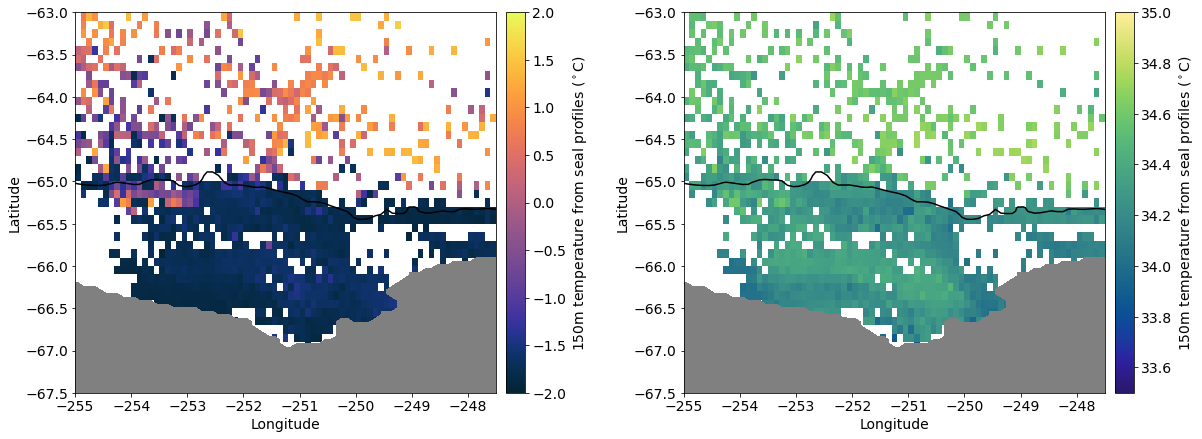

In [16]:
# plot 200m slice:
fontsize = 14
depth_slice = 150

plt.figure(figsize=(20,7))
plt.subplot(1, 2, 1)
sc=plt.pcolormesh(binned_meop_temp150.lon_bin-360,binned_meop_temp150.lat_bin,binned_meop_temp150,cmap=cmocean.thermal,vmin=-2,vmax=2)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temperature from seal profiles ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67.5, -63))
plt.xlim((-255, -247.5))
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)

plt.subplot(1, 2, 2)
sc=plt.pcolormesh(binned_meop_sal150.lon_bin-360,binned_meop_sal150.lat_bin,binned_meop_sal150,cmap=cmocean.haline,vmin=33.5,vmax=35)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temperature from seal profiles ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67.5, -63))
plt.xlim((-255, -247.5))
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)

#figure_path = figdir+'/seal_temp_map_'+str(depth_slice)+'m.png'
#plt.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1,facecolor='white')

## Here we are going to calculate T & S bias between model and data for 150 m and 550 m

In [30]:
mean_temp_150 = binned_meop_temp150.mean()
mean_model_150 = temp_150m_avg.mean()
bias_t150 = mean_temp_150 - mean_model_150

mean_temp_550 = binned_meop_temp550.mean()
mean_model_550 = temp_550m_avg.mean()
bias_t550 = mean_temp_550 - mean_model_550

mean_sal_150 = binned_meop_sal150.mean()
mean_model_s150 = sal_150m_avg.mean()
bias_s150 = mean_sal_150 - mean_model_s150

mean_sal_550 = binned_meop_sal550.mean()
mean_model_s550 = sal_550m_avg.mean()
bias_s550 = mean_sal_550 - mean_model_s550


print(bias_t150)
print(bias_t550)
print(bias_s150)
print(bias_s550)

<xarray.DataArray ()>
array(-0.81337427)
Coordinates:
    st_ocean  float64 150.6
<xarray.DataArray ()>
array(-0.74091248)
Coordinates:
    st_ocean  float64 571.6
<xarray.DataArray ()>
array(-0.12658335)
Coordinates:
    st_ocean  float64 150.6
<xarray.DataArray ()>
array(-0.08198687)
Coordinates:
    st_ocean  float64 571.6


### Unite both plots

### Temperature validation

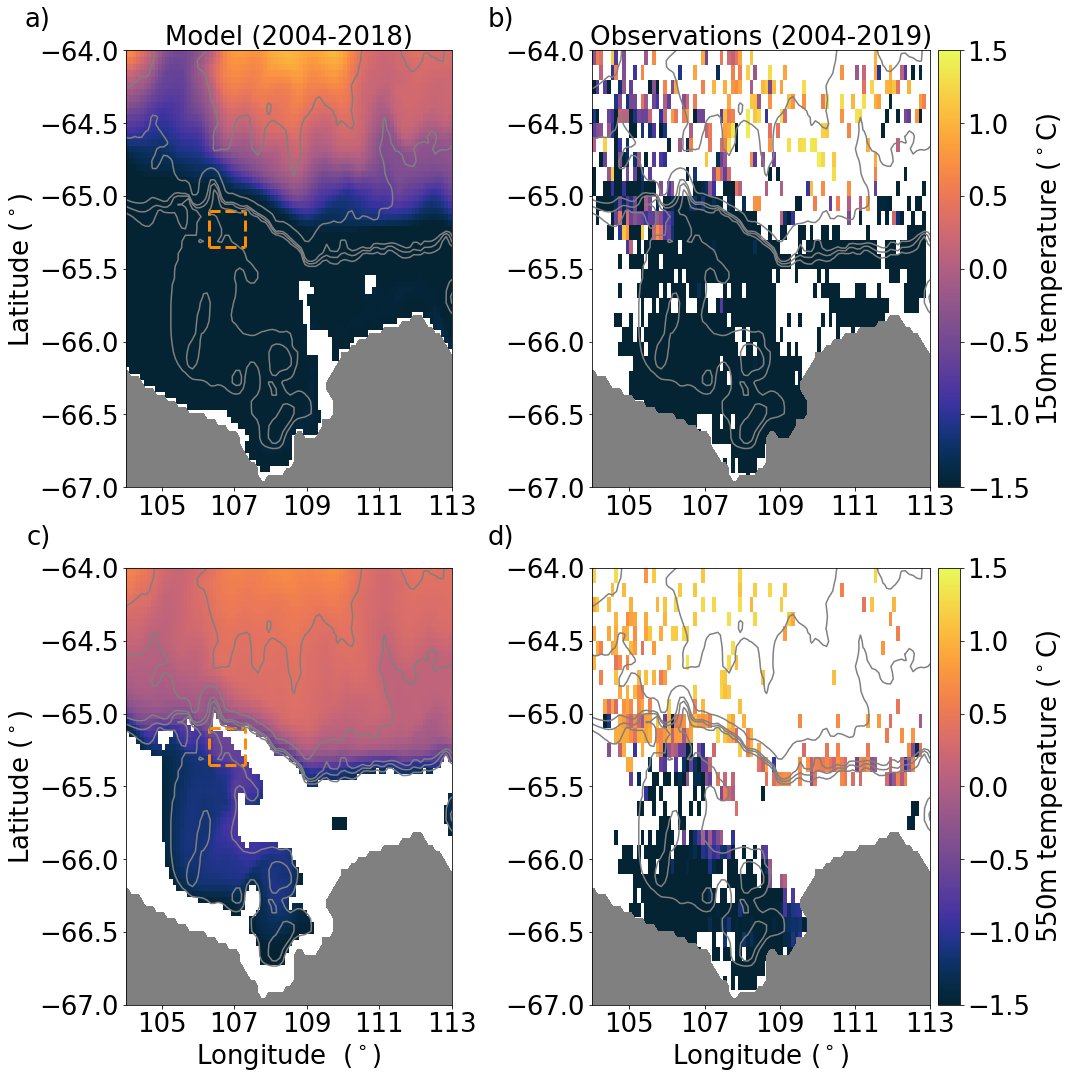

In [18]:
#Prepping variables to plot
fontsize=26

fig=plt.figure(figsize=(15, 15))
fig.subplots_adjust(top=0.88)
    
ax0=plt.subplot(2,2,1)   
depth_slice = 150
pc = plt.pcolormesh(temp_150m_avg.xt_ocean,temp_150m_avg.yt_ocean,
                        temp_150m_avg, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1.5)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='darkorange',linestyle='--',linewidth=3)

#plt.title('Model (2004-2018)',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.title('Model (2004-2018)',fontsize=fontsize)
#plt.xlabel('Longitude  ($^\circ$)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(str(depth_slice)+'m temperature from IAF3 ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticks([-254, -252, -250, -248, -246]) 
ax0.set_xticklabels([-254+359,-252+359,-250+359,-248+359,-246+359])

# Add subplot label
ax0.text(-0.23, 1.1, 'a)', transform=ax0.transAxes, fontsize=26, va='top', ha='right')

ax1=plt.subplot(2,2,2)    

sc=plt.pcolormesh(binned_meop_temp150.lon_bin-360,binned_meop_temp150.lat_bin,binned_meop_temp150,cmap=cmocean.thermal,vmin=-1.5,vmax=1.5)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temperature ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
#plt.title('Observations (2004-2019)',fontsize=fontsize)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -248))
plt.tick_params(labelsize=fontsize)
plt.title('Observations (2004-2019)',fontsize=fontsize)
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax1.set_xticks([-254, -252, -250, -248, -246]) 
ax1.set_xticklabels([-254+359,-252+359,-250+359,-248+359,-246+359])


# Add subplot label
ax1.text(-0.23, 1.1, 'b)', transform=ax1.transAxes, fontsize=26, va='top', ha='right')


ax0=plt.subplot(2,2,3)      
depth_slice = 550
pc = plt.pcolormesh(temp_550m_avg.xt_ocean,temp_550m_avg.yt_ocean,
                        temp_550m_avg, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1.5)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='darkorange',linestyle='--',linewidth=3)

#plt.title('Model (2004-2018)',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude  ($^\circ$)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(str(depth_slice)+'m temperature from IAF3 ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticks([-254, -252, -250, -248, -246]) 
ax0.set_xticklabels([-254+359,-252+359,-250+359,-248+359,-246+359])



# Add subplot label
ax0.text(-0.23, 1.1, 'c)', transform=ax0.transAxes, fontsize=26, va='top', ha='right')


ax1=plt.subplot(2,2,4)    

sc=plt.pcolormesh(binned_meop_temp550.lon_bin-360,binned_meop_temp550.lat_bin,binned_meop_temp550,cmap=cmocean.thermal,vmin=-1.5,vmax=1.5)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temperature ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
#plt.title('Observations (2004-2019)',fontsize=fontsize)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -248))
plt.tick_params(labelsize=fontsize)
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
#plt.set_xticks([-255,-254,-253,-252,-251,-250,-249,-248])
ax1.set_xticks([-254, -252, -250, -248, -246]) 
ax1.set_xticklabels([-254+359,-252+359,-250+359,-248+359,-246+359])


# Add subplot label
ax1.text(-0.23, 1.1, 'd)', transform=ax1.transAxes, fontsize=26, va='top', ha='right')


# this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])
fig.delaxes(fig.axes[4])

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/FigS1_Figure_validation_temp.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

### Salinity Validation

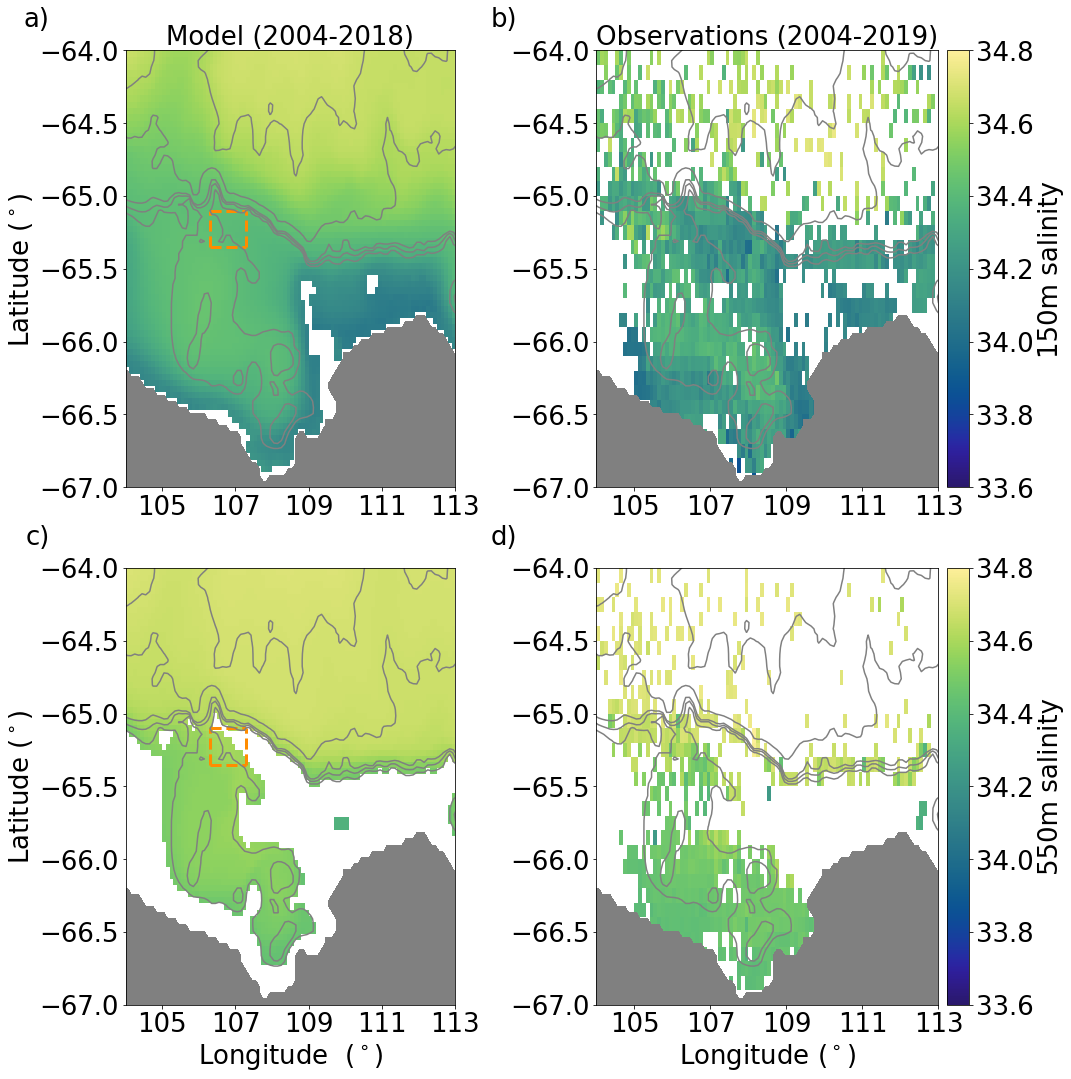

In [19]:
#Prepping variables to plot
fontsize=26

#for nt in range(0,nframes):
fig=plt.figure(figsize=(15, 15))
fig.subplots_adjust(top=0.88)
    
ax0=plt.subplot(2,2,1)   
depth_slice = 150
pc = plt.pcolormesh(sal_150m_avg.xt_ocean,sal_150m_avg.yt_ocean,
                        sal_150m_avg, cmap = cmocean.haline, 
                        vmin=33.6,vmax=34.8)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='darkorange',linestyle='--',linewidth=3)

#plt.title('Model (2004-2018)',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.title('Model (2004-2018)',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude  ($^\circ$)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=7)
cbar.set_label(str(depth_slice)+'m temperature from IAF3 ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticks([-254, -252, -250, -248, -246]) 
ax0.set_xticklabels([-254+359,-252+359,-250+359,-248+359,-246+359])


# Add subplot label
ax0.text(-0.23, 1.1, 'a)', transform=ax0.transAxes, fontsize=26, va='top', ha='right')

ax1=plt.subplot(2,2,2)    
sc=plt.pcolormesh(binned_meop_sal150.lon_bin-360,binned_meop_sal150.lat_bin,binned_meop_sal150,cmap=cmocean.haline,vmin=33.6,vmax=34.8)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m salinity',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
#plt.title('Observations (2004-2019)',fontsize=fontsize)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -248))
plt.tick_params(labelsize=fontsize)
plt.title('Observations (2004-2019)',fontsize=fontsize)
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
ax1.set_xticks([-254, -252, -250, -248, -246]) 
ax1.set_xticklabels([-254+359,-252+359,-250+359,-248+359,-246+359])


# Add subplot label
ax1.text(-0.23, 1.1, 'b)', transform=ax1.transAxes, fontsize=26, va='top', ha='right')

ax0=plt.subplot(2,2,3)      
depth_slice = 550
pc = plt.pcolormesh(sal_550m_avg.xt_ocean,sal_550m_avg.yt_ocean,
                        sal_550m_avg, cmap = cmocean.haline, 
                        vmin=33.6,vmax=34.8)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='darkorange',linestyle='--',linewidth=3)

#plt.title('Model (2004-2018)',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude  ($^\circ$)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=7)
cbar.set_label(str(depth_slice)+'m temperature from IAF3 ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticks([-254, -252, -250, -248, -246]) 
ax0.set_xticklabels([-254+359,-252+359,-250+359,-248+359,-246+359])


# Add subplot label
ax0.text(-0.23, 1.1, 'c)', transform=ax0.transAxes, fontsize=26, va='top', ha='right')

ax1=plt.subplot(2,2,4)    

sc=plt.pcolormesh(binned_meop_sal550.lon_bin-360,binned_meop_sal550.lat_bin,binned_meop_sal550,cmap=cmocean.haline,vmin=33.6,vmax=34.8)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m salinity',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
#plt.title('Observations (2004-2019)',fontsize=fontsize)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -248))
plt.tick_params(labelsize=fontsize)
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
ax1.set_xticks([-254, -252, -250, -248, -246]) 
ax1.set_xticklabels([-254+359,-252+359,-250+359,-248+359,-246+359])


# Add subplot label
ax1.text(-0.23, 1.1, 'd)', transform=ax1.transAxes, fontsize=26, va='top', ha='right')

# this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])
fig.delaxes(fig.axes[4])

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/FigS2_Figure_validation_sal.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')